# LOOPBACK TESTER

This notebook is useful for loopback tests when you have some Borealis data you would like to verify. This notebook is built off of the original test_beamforming.py script that I wrote in Nov/Dec 2018 to verify beamforming algorithms in Borealis. However, these analyses are useful to verify data after any update to the Borealis code. What follows is a list of functions that I plan to build into this script. - Marci Detwiller Feb 2019

**If only release-mode data is available for a given time, this notebook will:**
1. Plot the time domain data, or a portion of the data 
2. Verify location of the pulses in the data and pulse length
3. Plot the frequency spectrum and find the peaks 
4. Verify the beamforming if output_samples_iq is available

**If debug-mode data is available (rawrf, txdata, stage_1_iq, etc.), this notebook will also:**
1. Verify the rawrf from the txdata
2. Find the peaks of the FFT in the rawrf data and compare to the bfiq data to verify the decimation




In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
import deepdish
import numpy as np
import random

sys.path.append("../plot_borealis_hdf5_data/")

from plotting_borealis_data_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
filename = "/home/radar/loopback_test_data/20220608.1546.00.sas.0.antennas_iq.hdf5.site"
data_file = os.path.basename(filename)
data_directory = os.path.dirname(
    filename
)  # get directory outside of the data (/data/borealis_data)

record_name = None  # or change if you want a specific record

In [21]:
# get the corresponding data files to this data file, including output_samples_iq, bfiq,
# rawrf, txdata if available.

data_file_metadata = data_file.split(".")

date_of_file = data_file_metadata[0]
timestamp_of_file = ".".join(data_file_metadata[0:3])
station_name = data_file_metadata[3]
slice_id_number = data_file_metadata[4]

file_suffix = data_file_metadata[-1]

if file_suffix not in ["hdf5", "site"]:
    raise Exception("Incorrect File Suffix: {}".format(file_suffix))

if file_suffix == "hdf5":
    type_of_file = data_file_metadata[-2]  # XX.hdf5
else:
    type_of_file = data_file_metadata[-3]  # XX.hdf5.site

if type_of_file == slice_id_number:
    slice_id_number = "0"  # choose the first slice to search for other available files.
else:
    type_of_file = slice_id_number + "." + type_of_file


antennas_iq_filetype = slice_id_number + ".antennas_iq"
bfiq_filetype = slice_id_number + ".bfiq"
stage_1_filetype = slice_id_number + ".stage_1_iq"
stage_2_filetype = slice_id_number + ".stage_2_iq"
stage_3_filetype = slice_id_number + ".stage_3_iq"
# stage 4 = output_samples_iq so unnecessary
rawrf_filetype = "rawrf"
tx_filetype = "txdata"
output_samples_filetype = ""  # Added to remove exception further down
file_types_avail = [
    bfiq_filetype,
    tx_filetype,
    rawrf_filetype,
    antennas_iq_filetype,
    stage_1_filetype,
    stage_2_filetype,
    stage_3_filetype,
]

if type_of_file not in file_types_avail:
    raise Exception(
        "Data type: {} not incorporated in script. Allowed types: {}".format(
            type_of_file, file_types_avail
        )
    )

data = {}
print("Available Filetypes: ")
for file_type in list(
    file_types_avail
):  # copy of file_types_avail so we can modify it within.
    try:
        filename = (
            data_directory
            + "/"
            + timestamp_of_file
            + "."
            + station_name
            + "."
            + file_type
            + ".hdf5.site"
        )
        data[file_type] = deepdish.io.load(filename)
        print(file_type)
    except:
        file_types_avail.remove(file_type)
        if file_type == type_of_file:  # if this is the filename you provided.
            raise

Available Filetypes: 
0.bfiq
0.antennas_iq


In [22]:
# Choose a record from the provided file, and get that record for each filetype to analyze side by side.
# Also reshaping data to correct dimensions - if there is a problem with reshaping, we will also not use that record.

good_record_found = False
record_attempts = 0
while not good_record_found:
    if record_name is None:
        record_name = random.choice(list(data[type_of_file].keys()))
    print("Record Name Chosen: {}".format(record_name))
    record_data = {}

    try:
        for file_type in file_types_avail:
            record_data[file_type] = data[file_type][record_name]

            if file_type == bfiq_filetype:
                bf_iq = record_data[bfiq_filetype]

            if file_type == output_samples_filetype:
                output_samples_iq = record_data[output_samples_filetype]

            if file_type == rawrf_filetype:
                rawrf = record_data[rawrf_filetype]

            # tx data does not need to be reshaped.
            if file_type == tx_filetype:
                tx = record_data[tx_filetype]

    except ValueError as e:
        print(
            "Record {} raised an exception in filetype {}:\n".format(
                record_name, file_type
            )
        )
        traceback.print_exc()
        print("\nA new record will be selected.")
        record_attempts += 1
        if record_attempts == 3:
            print("FILES FAILED WITH 3 FAILED ATTEMPTS TO LOAD RECORDS.")
            raise  # something is wrong with the files
    else:  # no errors
        good_record_found = True

if bfiq_filetype not in file_types_avail:
    raise Exception("BFIQ data is required to do tests and could not be loaded.")

Record Name Chosen: 1654703195140


In [23]:
print(record_data[stage_1_filetype].keys())
print(record_data[stage_1_filetype]["data_descriptors"])

KeyError: '0.stage_1_iq'

Sequence number: 0
Antennas: ['antenna_0', 'antenna_1', 'antenna_2', 'antenna_3', 'antenna_4', 'antenna_5', 'antenna_6', 'antenna_7', 'antenna_8', 'antenna_9', 'antenna_10', 'antenna_11', 'antenna_12', 'antenna_13', 'antenna_14', 'antenna_15', 'antenna_16', 'antenna_17', 'antenna_18', 'antenna_19']


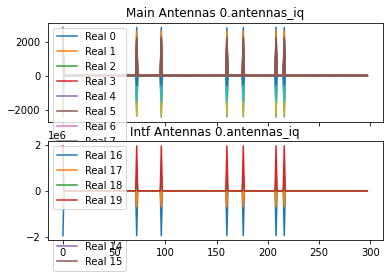

Sequence number: 0
Beam number: 0


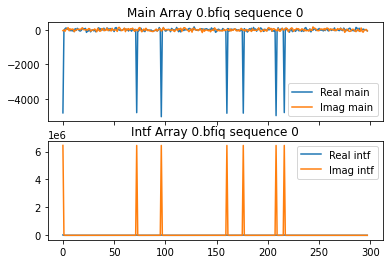

In [26]:
# plot_output_samples_iq_data(record_data[stage_1_filetype], stage_1_filetype)
# plot_output_samples_iq_data(record_data[stage_2_filetype], stage_2_filetype)
# plot_output_samples_iq_data(record_data[stage_3_filetype], stage_3_filetype)
plot_antennas_iq_data(record_data[antennas_iq_filetype], antennas_iq_filetype)


plot_bf_iq_data(record_data[bfiq_filetype], bfiq_filetype)

# We should see pulses in loopback data. We should see only noise perhaps with some leakage
# if a channel is not connected (i.e. intf channels in loopback tests)

In [52]:
# print(record_data[tx_filetype]['dm_rate'])

In [53]:
# In loopback data, we expect to see the peak of the FFT at our transmitted frequency. We expect to see
# other peaks at 666.6 Hz off of the txfreq, because this is the periodicity of our signal (1.5ms = tau)


# fft_samps, xf, fig = fft_and_plot_bfiq_data(record_data[bfiq_filetype], 'bfiq')
# fft_samps, xf, fig = fft_and_plot_output_samples_iq(record_data[output_samples_filetype], 'output_samples')
# fft_samps, xf, fig = fft_and_plot_output_samples_iq(record_data[stage_1_filetype], 'stage 1', plot_width=50)
# fft_samps, xf, fig = fft_and_plot_output_samples_iq(record_data[stage_2_filetype], 'stage 2', plot_width=100)
# fft_samps, xf, fig = fft_and_plot_output_samples_iq(record_data[stage_3_filetype], 'stage 3')

# fft_and_plot_rawrf_data(record_data[rawrf_filetype], 'rawrf', plot_width=20000, start_sample=0, end_sample=-1, center=-500000)
# fft_and_plot_txdata(record_data[tx_filetype], 'txdata')
# plt.show()

3333.3333333333335
Sequence number: 0
Antennas: ['antenna_0', 'antenna_1', 'antenna_2', 'antenna_3', 'antenna_4', 'antenna_5', 'antenna_6', 'antenna_7', 'antenna_8', 'antenna_9', 'antenna_10', 'antenna_11', 'antenna_12', 'antenna_13', 'antenna_14', 'antenna_15', 'antenna_16', 'antenna_17', 'antenna_18', 'antenna_19']


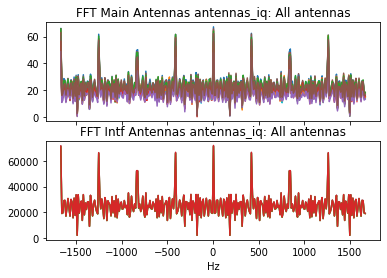

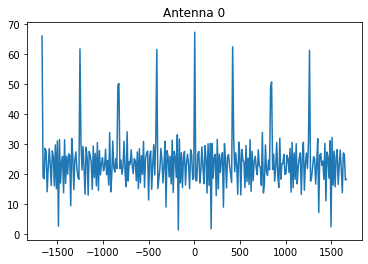

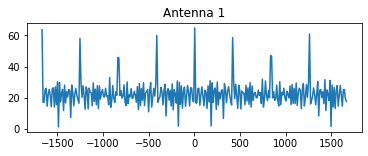

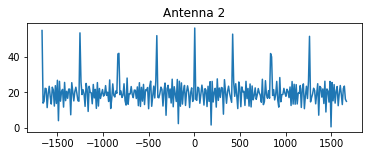

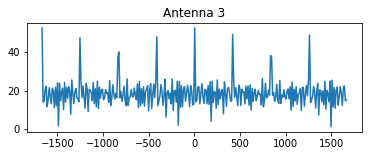

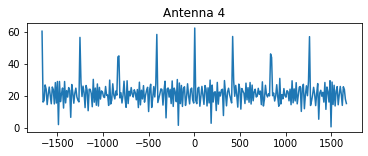

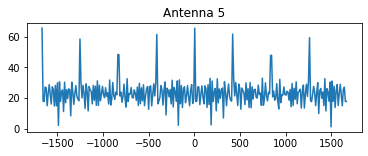

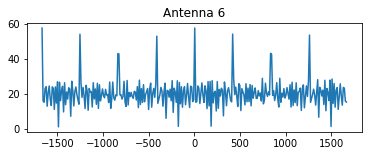

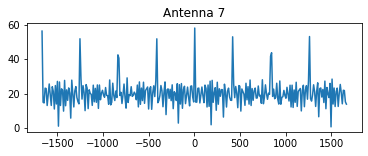

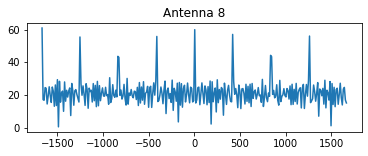

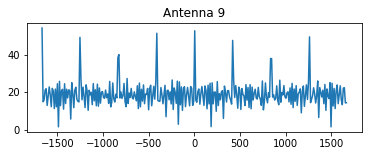

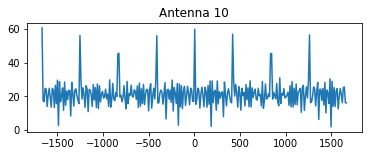

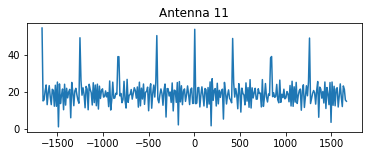

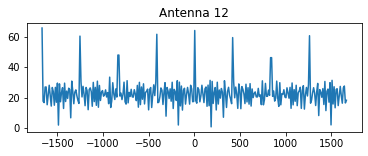

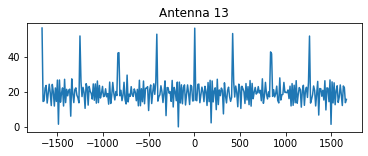

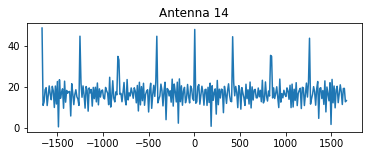

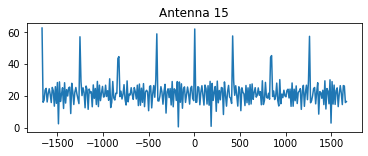

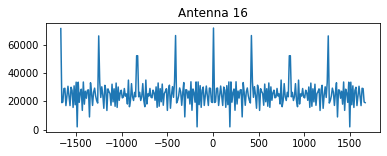

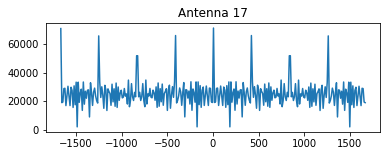

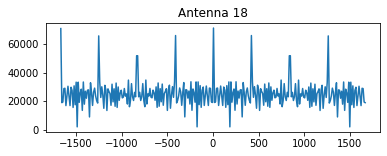

<Figure size 432x288 with 0 Axes>

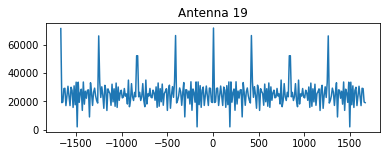

In [54]:
print(record_data[antennas_iq_filetype]["rx_sample_rate"])
fft_samps, xf, fig = fft_and_plot_antennas_iq(
    record_data[antennas_iq_filetype], "antennas_iq"
)
plt.show()